<a href="https://colab.research.google.com/github/Axle-Bucamp/Proposition-architechture-Deep-learning/blob/main/Downsampling-with-memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras 
import numpy

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [2]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [4]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [5]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

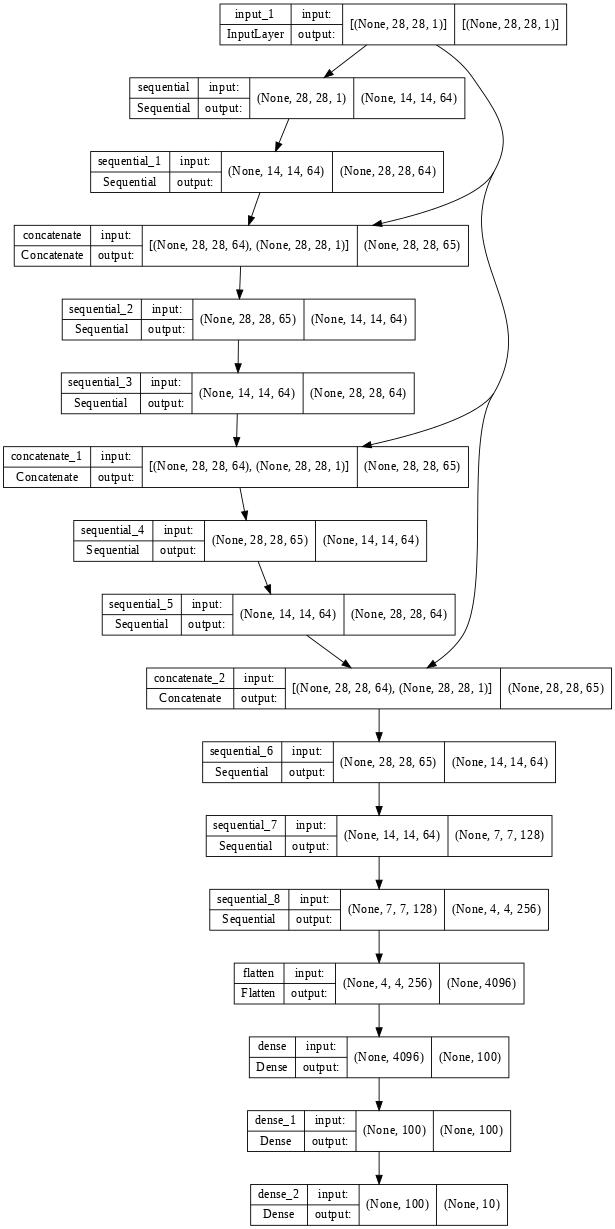

In [6]:
inputs = tf.keras.layers.Input(shape=[28, 28, 1])

# part find interest point and compute dist between each pixel like 
down = downsample(64, 4, apply_batchnorm=False)(inputs)
up = upsample(64, 4, apply_dropout=True)(down)
model = tf.keras.layers.Concatenate()([up, inputs])
down = downsample(64, 4, apply_batchnorm=False)(model)
up = upsample(64, 4, apply_dropout=True)(down)
model = tf.keras.layers.Concatenate()([up, inputs])
down = downsample(64, 4, apply_batchnorm=False)(model)
up = upsample(64, 4, apply_dropout=True)(down)
model = tf.keras.layers.Concatenate()([up, inputs])

# part analising (classique: conv + relu)
down = downsample(64, 4, apply_batchnorm=False)(model)
down = downsample(128, 4, apply_batchnorm=False)(down)
down = downsample(256, 4, apply_batchnorm=False)(down)
model = tf.keras.layers.Flatten()(down)
model = tf.keras.layers.Dense(100)(model)
model = tf.keras.layers.Dense(100)(model)
out = tf.keras.layers.Dense(10)(model) #,activation="softmax"


model = tf.keras.Model(inputs=inputs, outputs=out)
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [7]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [8]:
ds_train.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [9]:
model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 [==============================] - 42s 44ms/step - loss: 0.2151 - sparse_categorical_accuracy: 0.9321 - val_loss: 0.0859 - val_sparse_categorical_accuracy: 0.9726
Epoch 2/6
469/469 [==============================] - 21s 44ms/step - loss: 0.0788 - sparse_categorical_accuracy: 0.9758 - val_loss: 0.0628 - val_sparse_categorical_accuracy: 0.9820
Epoch 3/6
469/469 [==============================] - 21s 45ms/step - loss: 0.0608 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.0569 - val_sparse_categorical_accuracy: 0.9836
Epoch 4/6
469/469 [==============================] - 21s 45ms/step - loss: 0.0522 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.0432 - val_sparse_categorical_accuracy: 0.9855
Epoch 5/6
469/469 [==============================] - 21s 45ms/step - loss: 0.0430 - sparse_categorical_accuracy: 0.9868 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9893
Epoch 6/6
469/469 [==============================] - 22s 46ms/step - loss: 0.0415 - sparse_cate

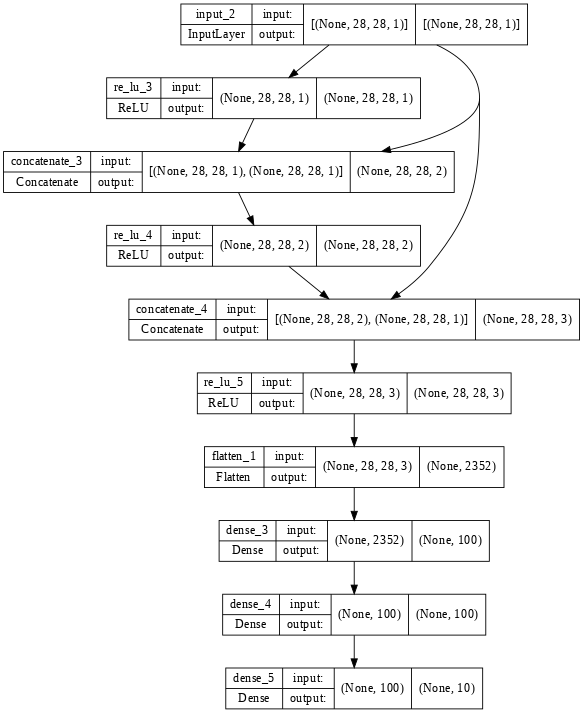

In [10]:
inputs = tf.keras.layers.Input(shape=[28, 28, 1])

# part find interest point and compute dist between each pixel like 
down = tf.keras.layers.ReLU()(inputs)
model = tf.keras.layers.Concatenate()([down, inputs])
down = tf.keras.layers.ReLU()(model)
model = tf.keras.layers.Concatenate()([down, inputs])
down = tf.keras.layers.ReLU()(model)

# part analising (classique: conv + relu)
model = tf.keras.layers.Flatten()(down)
model = tf.keras.layers.Dense(100)(model)
model = tf.keras.layers.Dense(100)(model)
out = tf.keras.layers.Dense(10)(model) #,activation="softmax"


model = tf.keras.Model(inputs=inputs, outputs=out)
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [11]:
model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 [==============================] - 2s 4ms/step - loss: 0.3996 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.3101 - val_sparse_categorical_accuracy: 0.9138
Epoch 2/6
469/469 [==============================] - 2s 4ms/step - loss: 0.3025 - sparse_categorical_accuracy: 0.9153 - val_loss: 0.3057 - val_sparse_categorical_accuracy: 0.9204
Epoch 3/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2896 - sparse_categorical_accuracy: 0.9197 - val_loss: 0.2996 - val_sparse_categorical_accuracy: 0.9177
Epoch 4/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2844 - sparse_categorical_accuracy: 0.9206 - val_loss: 0.2906 - val_sparse_categorical_accuracy: 0.9202
Epoch 5/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2798 - sparse_categorical_accuracy: 0.9218 - val_loss: 0.2805 - val_sparse_categorical_accuracy: 0.9241
Epoch 6/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2736 - sparse_categorical_accu

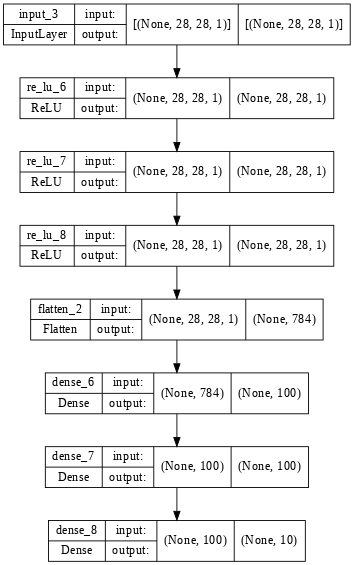

In [12]:
inputs = tf.keras.layers.Input(shape=[28, 28, 1])

# part find interest point and compute dist between each pixel like 
down = tf.keras.layers.ReLU()(inputs)
down = tf.keras.layers.ReLU()(down)
down = tf.keras.layers.ReLU()(down)

# part analising (classique: conv + relu)
model = tf.keras.layers.Flatten()(down)
model = tf.keras.layers.Dense(100)(model)
model = tf.keras.layers.Dense(100)(model)
out = tf.keras.layers.Dense(10)(model) #,activation="softmax"


model = tf.keras.Model(inputs=inputs, outputs=out)
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [13]:
model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 [==============================] - 2s 4ms/step - loss: 0.3682 - sparse_categorical_accuracy: 0.8945 - val_loss: 0.2988 - val_sparse_categorical_accuracy: 0.9149
Epoch 2/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2916 - sparse_categorical_accuracy: 0.9193 - val_loss: 0.2871 - val_sparse_categorical_accuracy: 0.9204
Epoch 3/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2788 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.2858 - val_sparse_categorical_accuracy: 0.9192
Epoch 4/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2724 - sparse_categorical_accuracy: 0.9245 - val_loss: 0.2863 - val_sparse_categorical_accuracy: 0.9197
Epoch 5/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2696 - sparse_categorical_accuracy: 0.9257 - val_loss: 0.2766 - val_sparse_categorical_accuracy: 0.9220
Epoch 6/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2660 - sparse_categorical_accu